In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import pandas as pd
import os
import joblib
import math

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Reshape, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from img2vec import grayscale2emb

### Check for GPU

In [3]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Print GPU information
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Name:", gpu.name, "  Type:", gpu.device_type)

    # Set memory growth to avoid using all GPU memory
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    print("GPU is available for TensorFlow!")
else:
    print("No GPU found. TensorFlow will use CPU.")

Num GPUs Available:  0
No GPU found. TensorFlow will use CPU.


### Set random seed for reproducibility

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

### Load data

In [5]:
data_dir = os.path.join('..', '..', 'data')
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
val_data = pd.read_csv(os.path.join(data_dir, 'val.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))

### Print dataset information

In [6]:
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 11856
Validation set size: 2964
Test set size: 3731


### Check if images exist and filter

In [7]:
def construct_img_path(row):
    return os.path.join(data_dir, 'faces', row['user_id'], 
                      f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}")

train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)

train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

# Filter to include only rows where images exist
train_data = train_data[train_data['img_exists'] == True]
val_data = val_data[val_data['img_exists'] == True]
test_data = test_data[test_data['img_exists'] == True]

Encode labels

In [8]:
if os.path.exists('age_encoder.pkl') and os.path.exists('gender_encoder.pkl'):
    age_encoder = joblib.load('age_encoder.pkl')
    gender_encoder = joblib.load('gender_encoder.pkl')
    print("Age and gender encoders loaded successfully.")
    
    # Add these lines to encode train data when loading existing encoders
    train_data['age_encoded'] = age_encoder.transform(train_data['age'])
    train_data['gender_encoded'] = gender_encoder.transform(train_data['gender'])
else:
    # Remove rare classes
    age_counts = train_data['age'].value_counts()
    gender_counts = train_data['gender'].value_counts()
    rare_ages = age_counts[age_counts < 5].index.tolist()
    rare_genders = gender_counts[gender_counts < 5].index.tolist()
    
    # Filter data
    train_data = train_data[~train_data['age'].isin(rare_ages) & ~train_data['gender'].isin(rare_genders)]
    
    # Create encoders
    age_encoder = LabelEncoder()
    gender_encoder = LabelEncoder()
    train_data['age_encoded'] = age_encoder.fit_transform(train_data['age'])
    train_data['gender_encoded'] = gender_encoder.fit_transform(train_data['gender'])
    
    # Save encoders
    joblib.dump(age_encoder, 'age_encoder.pkl')
    joblib.dump(gender_encoder, 'gender_encoder.pkl')
    print("Encoders created and saved.")

# Filter validation and test data to include only seen classes
val_data = val_data[val_data['age'].isin(age_encoder.classes_)]
val_data = val_data[val_data['gender'].isin(gender_encoder.classes_)]
test_data = test_data[test_data['age'].isin(age_encoder.classes_)]
test_data = test_data[test_data['gender'].isin(gender_encoder.classes_)]

# Encode the labels
val_data['age_encoded'] = age_encoder.transform(val_data['age'])
val_data['gender_encoded'] = gender_encoder.transform(val_data['gender'])
test_data['age_encoded'] = age_encoder.transform(test_data['age'])
test_data['gender_encoded'] = gender_encoder.transform(test_data['gender'])

num_age_classes = len(age_encoder.classes_)
num_gender_classes = len(gender_encoder.classes_)
print(f"Age classes: {age_encoder.classes_}")
print(f"Gender classes: {gender_encoder.classes_}")

Age and gender encoders loaded successfully.
Age classes: ['(0, 2)' '(15, 20)' '(25, 32)' '(38, 43)' '(4, 6)' '(48, 53)' '(60, 100)'
 '(8, 23)']
Gender classes: ['f' 'm' 'u']


### Define function that processes features in batches and stores them to avoid recomputation

In [9]:
def preprocess_and_save_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)

    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{math.ceil(len(image_paths) / batch_size)}")
        batch_features = grayscale2emb(batch_paths)
        all_features.append(batch_features)

    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Process and save features

In [10]:
if not os.path.exists('train_features.npy'):
    train_features = preprocess_and_save_features(train_data['img_path'].tolist(), 'train_features.npy')
    val_features = preprocess_and_save_features(val_data['img_path'].tolist(), 'val_features.npy')
    test_features = preprocess_and_save_features(test_data['img_path'].tolist(), 'test_features.npy')
else:
    train_features = np.load('train_features.npy')
    val_features = np.load('val_features.npy')
    test_features = np.load('test_features.npy')

### Standardize features

In [11]:
if os.path.exists('feature_scaler.pkl'):
    scaler = joblib.load('feature_scaler.pkl')
    print("Feature scaler loaded successfully.")
else:
    scaler = StandardScaler()
    scaler.fit(train_features)
    joblib.dump(scaler, 'feature_scaler.pkl')
    print("Feature scaler created and saved.")

train_features_scaled = scaler.transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

Feature scaler loaded successfully.


### Define LSTM model

In [12]:
def reshape_features_for_lstm(features, time_steps=16):
    """Reshape features to be compatible with LSTM input shape (batch, time_steps, features)"""
    feature_dim = features.shape[1]
    # Determine the feature size per time step
    features_per_step = feature_dim // time_steps
    
    # If features aren't cleanly divisible, we'll pad
    if feature_dim % time_steps != 0:
        pad_size = time_steps - (feature_dim % time_steps)
        features = np.pad(features, ((0, 0), (0, pad_size)), 'constant')
        feature_dim = features.shape[1]
        features_per_step = feature_dim // time_steps
    
    # Reshape to (batch, time_steps, features_per_step)
    return features.reshape(features.shape[0], time_steps, features_per_step)

# Reshape data for LSTM
time_steps = 16  # You can adjust this value
train_features_lstm = reshape_features_for_lstm(train_features_scaled, time_steps)
val_features_lstm = reshape_features_for_lstm(val_features_scaled, time_steps)
test_features_lstm = reshape_features_for_lstm(test_features_scaled, time_steps)

def create_lstm_age_model(input_shape, num_age_classes):
    input_layer = Input(shape=input_shape)
    
    # LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    # Dense layers for classification
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    age_output = Dense(num_age_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=age_output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_lstm_gender_model(input_shape, num_gender_classes):
    input_layer = Input(shape=input_shape)
    
    # LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    # Dense layers for classification
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    gender_output = Dense(num_gender_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=gender_output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create LSTM models
lstm_input_shape = (train_features_lstm.shape[1], train_features_lstm.shape[2])
age_model = create_lstm_age_model(lstm_input_shape, num_age_classes)
gender_model = create_lstm_gender_model(lstm_input_shape, num_gender_classes)

# Print model summaries
print("Age Model Summary:")
age_model.summary()
print("\nGender Model Summary:")
gender_model.summary()

# Define callbacks for age model
age_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_lstm_age_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Define callbacks for gender model
gender_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_lstm_gender_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

Age Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 446,088 (1.70 MB)

 Trainable params: 445,576 (1.70 MB)

 Non-trainable params: 512 (2.00 KB)


Gender Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 16, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,443 (1.70 MB)

 Trainable params: 444,931 (1.70 MB)

 Non-trainable params: 512 (2.00 KB)

### Compute class weights and get labels

In [13]:
train_age_labels = train_data['age_encoded'].values
train_gender_labels = train_data['gender_encoded'].values
val_age_labels = val_data['age_encoded'].values
val_gender_labels = val_data['gender_encoded'].values

age_weights = compute_class_weight('balanced', classes=np.unique(train_data['age_encoded']), 
                                  y=train_data['age_encoded'])
gender_weights = compute_class_weight('balanced', classes=np.unique(train_data['gender_encoded']), 
                                     y=train_data['gender_encoded'])

### Train models

In [14]:
print("Training the LSTM age model...")
age_history = age_model.fit(
    train_features_lstm,
    train_age_labels,
    validation_data=(val_features_lstm, val_age_labels),
    epochs=30,
    batch_size=64,
    callbacks=age_callbacks,
    class_weight=dict(enumerate(age_weights))
)

print("Training the LSTM gender model...")
gender_history = gender_model.fit(
    train_features_lstm,
    train_gender_labels,
    validation_data=(val_features_lstm, val_gender_labels),
    epochs=30,
    batch_size=64,
    callbacks=gender_callbacks,
    class_weight=dict(enumerate(gender_weights))
)

Training the LSTM age model...
Epoch 1/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2295 - loss: 2.1912
Epoch 1: val_loss improved from inf to 1.57501, saving model to best_lstm_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.2302 - loss: 2.1872 - val_accuracy: 0.3745 - val_loss: 1.5750
Epoch 2/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3726 - loss: 1.5233
Epoch 2: val_loss improved from 1.57501 to 1.34579, saving model to best_lstm_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.3728 - loss: 1.5227 - val_accuracy: 0.4437 - val_loss: 1.3458
Epoch 3/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4456 - loss: 1.3175
Epoch 3: val_loss improved from 1.34579 to 1.28296, saving model to best_lstm_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4458 - loss: 1.3168 - val_accuracy: 0.4777 - val_loss: 1.2830
Epoch 4/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5042 - loss: 1.1477
Epoch 4: val_loss improved from 1.28296 to 1.25526, saving model to best_lstm_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5044 - loss: 1.1468 - val_accuracy: 0.5037 - val_loss: 1.2553
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5647 - loss: 0.9752
Epoch 5: val_loss did not improve from 1.25526
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5647 - loss: 0.9749 - val_accuracy: 0.4909 - val_loss: 1.3007
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6226 - loss: 0.8129
Epoch 6: val_loss did not improve from 1.25526
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6227 - loss: 0.8127 - val_accuracy: 0.5172 - val_loss: 1.2942
Epoch 7/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6743 - loss: 0.6675
Epoch 7: val_loss did not improve from 1.25526
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6743 - loss: 0.6672 - val_accuracy: 0.5287 - val_loss: 1.3197
Epoch 8/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7263 - loss: 0.5539
Epoch 8: val_loss did not improve from 

186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.5629 - loss: 0.9241 - val_accuracy: 0.7996 - val_loss: 0.5417
Epoch 2/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7506 - loss: 0.5295
Epoch 2: val_loss improved from 0.54169 to 0.47197, saving model to best_lstm_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7508 - loss: 0.5290 - val_accuracy: 0.8080 - val_loss: 0.4720
Epoch 3/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7982 - loss: 0.4293
Epoch 3: val_loss improved from 0.47197 to 0.46005, saving model to best_lstm_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7984 - loss: 0.4288 - val_accuracy: 0.8235 - val_loss: 0.4601
Epoch 4/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8439 - loss: 0.3249
Epoch 4: val_loss improved from 0.46005 to 0.43260, saving model to best_lstm_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8440 - loss: 0.3247 - val_accuracy: 0.8327 - val_loss: 0.4326
Epoch 5/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8855 - loss: 0.2406
Epoch 5: val_loss did not improve from 0.43260
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8855 - loss: 0.2405 - val_accuracy: 0.8360 - val_loss: 0.4891
Epoch 6/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9150 - loss: 0.1922
Epoch 6: val_loss did not improve from 0.43260
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9150 - loss: 0.1920 - val_accuracy: 0.8323 - val_loss: 0.5506
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9383 - loss: 0.1423
Epoch 7: val_loss did not improve from 0.43260
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9383 - loss: 0.1422 - val_accuracy: 0.8323 - val_loss: 0.6112
Epoch 8/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9522 - loss: 0.1152
Epoch 8: val_loss did not improve from 

### Save the model

In [15]:
age_model.save('lstm_age_model.h5')
gender_model.save('lstm_gender_model.h5')
print("LSTM models saved successfully.")

LSTM models saved successfully.


### Evaluate the model

In [16]:
# After training the separate LSTM models, we can evaluate them together:
print("Evaluating LSTM models...")

# Make predictions with both models
age_predictions = np.argmax(age_model.predict(test_features_lstm), axis=1)
gender_predictions = np.argmax(gender_model.predict(test_features_lstm), axis=1)

# Calculate individual accuracies
age_accuracy = np.mean(age_predictions == test_data['age_encoded'].values)
gender_accuracy = np.mean(gender_predictions == test_data['gender_encoded'].values)

# Calculate combined accuracy (both predictions correct)
correct_both = np.logical_and(
    age_predictions == test_data['age_encoded'].values,
    gender_predictions == test_data['gender_encoded'].values
)
combined_accuracy = np.mean(correct_both)

print(f"Age Accuracy: {age_accuracy:.4f}")
print(f"Gender Accuracy: {gender_accuracy:.4f}")
print(f"Combined Accuracy (both correct): {combined_accuracy:.4f}")

Evaluating LSTM models...
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Age Accuracy: 0.3506
Gender Accuracy: 0.7408
Combined Accuracy (both correct): 0.2498


### Generate classification reports

In [17]:
print("\nAge Classification Report:")
print(classification_report(test_data['age_encoded'].values, age_predictions, 
                         target_names=age_encoder.classes_))
print("\nGender Classification Report:")
print(classification_report(test_data['gender_encoded'].values, gender_predictions, 
                         target_names=gender_encoder.classes_))


Age Classification Report:
              precision    recall  f1-score   support

      (0, 2)       0.73      0.74      0.74       483
    (15, 20)       0.11      0.23      0.15       227
    (25, 32)       0.52      0.28      0.36      1036
    (38, 43)       0.22      0.22      0.22       543
      (4, 6)       0.54      0.46      0.50       570
    (48, 53)       0.13      0.25      0.18       258
   (60, 100)       0.38      0.24      0.30       274
     (8, 23)       0.18      0.29      0.22       340

    accuracy                           0.35      3731
   macro avg       0.35      0.34      0.33      3731
weighted avg       0.41      0.35      0.37      3731


Gender Classification Report:
              precision    recall  f1-score   support

           f       0.77      0.77      0.77      1848
           m       0.72      0.74      0.73      1597
           u       0.70      0.57      0.63       286

    accuracy                           0.74      3731
   macro avg      

### Plot training history

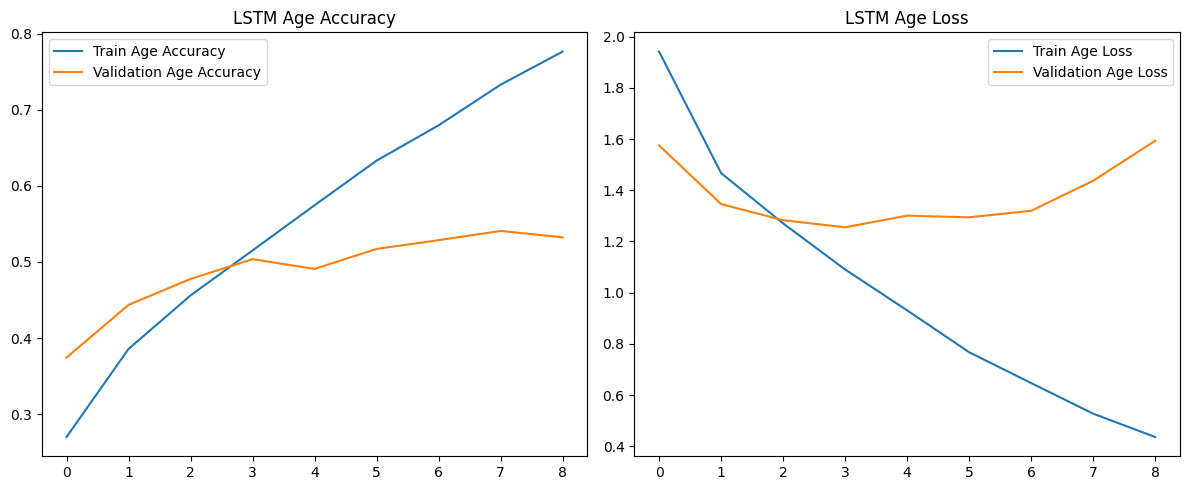

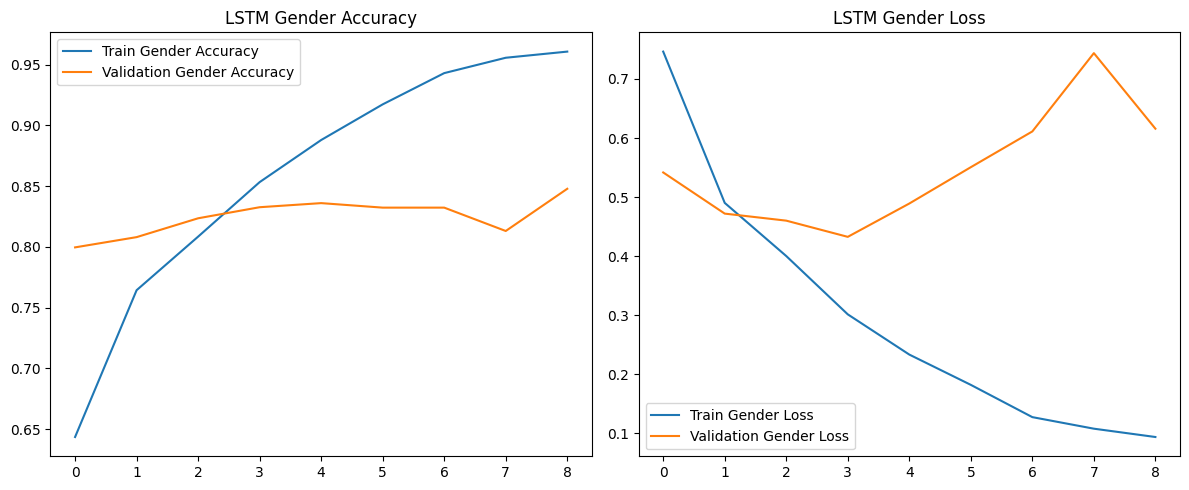

In [18]:
plt.figure(figsize=(12, 5))

# Age accuracy
plt.subplot(1, 2, 1)
plt.plot(age_history.history['accuracy'], label='Train Age Accuracy')
plt.plot(age_history.history['val_accuracy'], label='Validation Age Accuracy')
plt.title('LSTM Age Accuracy')
plt.legend()

# Age loss
plt.subplot(1, 2, 2)
plt.plot(age_history.history['loss'], label='Train Age Loss')
plt.plot(age_history.history['val_loss'], label='Validation Age Loss')
plt.title('LSTM Age Loss')
plt.legend()

plt.tight_layout()
plt.savefig('lstm_age_training_history.png')
plt.show()

# Visualize training history for gender model
plt.figure(figsize=(12, 5))

# Gender accuracy
plt.subplot(1, 2, 1)
plt.plot(gender_history.history['accuracy'], label='Train Gender Accuracy')
plt.plot(gender_history.history['val_accuracy'], label='Validation Gender Accuracy')
plt.title('LSTM Gender Accuracy')
plt.legend()

# Gender loss
plt.subplot(1, 2, 2)
plt.plot(gender_history.history['loss'], label='Train Gender Loss')
plt.plot(gender_history.history['val_loss'], label='Validation Gender Loss')
plt.title('LSTM Gender Loss')
plt.legend()

plt.tight_layout()
plt.savefig('lstm_gender_training_history.png')
plt.show()

### Example of how to load the model and use it for prediction

In [19]:
def predict_age_and_gender_with_lstm(image_path):
    """
    Load pre-trained LSTM models and predict age and gender from an image.
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        tuple: (age_range, gender) as strings
    """
    import numpy as np
    import os
    import joblib
    from tensorflow.keras.models import load_model
    from img2vec import grayscale2emb
    
    # Check if the image exists
    if not os.path.exists(image_path):
        return "Error: Image not found"
    
    # Load the models
    try:
        age_model = load_model('lstm_age_model.h5')
        gender_model = load_model('lstm_gender_model.h5')
    except Exception as e:
        return f"Error loading models: {str(e)}"
    
    # Load the encoders
    try:
        age_encoder = joblib.load('age_encoder.pkl')
        gender_encoder = joblib.load('gender_encoder.pkl')
        scaler = joblib.load('feature_scaler.pkl')
    except Exception as e:
        return f"Error loading encoders: {str(e)}"
    
    # Extract features from the image
    try:
        # Convert to batch format (list with single image)
        features = grayscale2emb([image_path])
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        # Reshape for LSTM input
        features_lstm = reshape_features_for_lstm(features_scaled, time_steps=16)
        
        # Make predictions
        age_pred = np.argmax(age_model.predict(features_lstm), axis=1)[0]
        gender_pred = np.argmax(gender_model.predict(features_lstm), axis=1)[0]
        
        # Convert numerical predictions to original labels
        age_range = age_encoder.inverse_transform([age_pred])[0]
        gender = gender_encoder.inverse_transform([gender_pred])[0]
        
        return (age_range, gender)
    
    except Exception as e:
        return f"Error during prediction: {str(e)}"

# Example usage:
age_range, gender = predict_age_and_gender_with_lstm("../../img.jpg")
print(f"Predicted Age Range: {age_range}")
print(f"Predicted Gender: {gender}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Predicted Age Range: (8, 23)
Predicted Gender: m
